# Stage 11 Homework — Evaluation & Risk Communication
In the lecture, we learned **parametric vs bootstrap CIs**, **scenario sensitivity**, and **subgroup checks**.
Now, you will adapt those methods to your dataset and produce assumption-aware results.

In [1]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
np.random.seed(111)
plt.rcParams['figure.figsize'] = (8,5)

## Load Data (provided or synthetic fallback)

In [3]:
from pathlib import Path
import pandas as pd
import numpy as np

data_dir = Path('../data')
data_dir.mkdir(exist_ok=True)

csv_path = data_dir / 'data_stage11_eval_risk.csv'

if csv_path.exists():
    try:
        df = pd.read_csv(csv_path, parse_dates=['date'])
    except ValueError as e:
        print(f"Error reading CSV: {e}\nRegenerating synthetic data...")
        regenerate = True
    else:
        regenerate = False
else:
    regenerate = True

if regenerate:
    n = 180
    dates = pd.date_range('2022-06-01', periods=n, freq='D')
    seg = np.random.choice(['A','B','C'], size=n, p=[0.5,0.3,0.2])
    x = np.linspace(0, 9, n) + np.random.normal(0, 0.7, n)
    y = 2.1 * x + 0.8 + np.random.standard_t(df=3, size=n) * 1.1
    x[np.random.choice(np.arange(n), size=round(0.05*n), replace=False)] = np.nan
    df = pd.DataFrame({'date': dates, 'segment': seg, 'x_feature': x, 'y_target': y})
    df.to_csv(csv_path, index=False)

df.head()


,date,segment,x_feature,y_target
0,2022-06-01,B,-0.923084,0.397744
1,2022-06-02,B,0.800028,3.393176
2,2022-06-03,C,-0.974879,-1.214004
3,2022-06-04,C,0.306383,2.368256
4,2022-06-05,C,0.528115,3.231590


## Helper Functions (complete or modify as needed)

In [12]:
import sys, os
sys.path.append(os.path.abspath(".."))  # allow from src import ...
from src.evaluation import mean_impute, median_impute, mae, bootstrap_metric, fit_fn, pred_fn

## Baseline Fit & Residuals (Required)

Base MAE: 1.4748085552801673


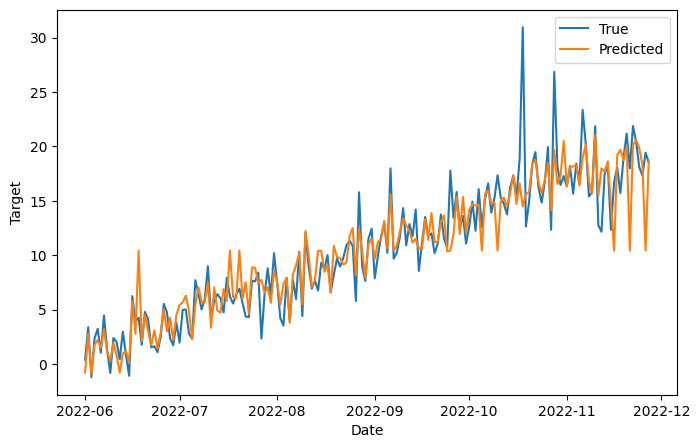

In [18]:
X_raw = df['x_feature'].values
y = df['y_target'].values

# Mean Imputation
X_base = mean_impute(X_raw)
model = fit_fn(X_base.reshape(-1,1), y)
y_hat = model.predict(X_base.reshape(-1,1))

df['x_imputed'] = X_base
df['y_hat'] = y_hat
df['resid'] = df['y_target'] - df['y_hat']

base_mae = mae(y, y_hat)
print("Base MAE:", base_mae)

plt.plot(df['date'], y, label='True')
plt.plot(df['date'], y_hat, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Target')
plt.legend()
plt.show()


In [19]:
df.head()

,date,segment,x_feature,y_target,x_imputed,y_hat,resid
0,2022-06-01,B,-0.923084,0.397744,-0.923084,-0.790492,1.188236
1,2022-06-02,B,0.800028,3.393176,0.800028,2.772281,0.620894
2,2022-06-03,C,-0.974879,-1.214004,-0.974879,-0.897586,-0.316418
3,2022-06-04,C,0.306383,2.368256,0.306383,1.751601,0.616655
4,2022-06-05,C,0.528115,3.231590,0.528115,2.210063,1.021527


## Parametric vs Bootstrap CI (Required)

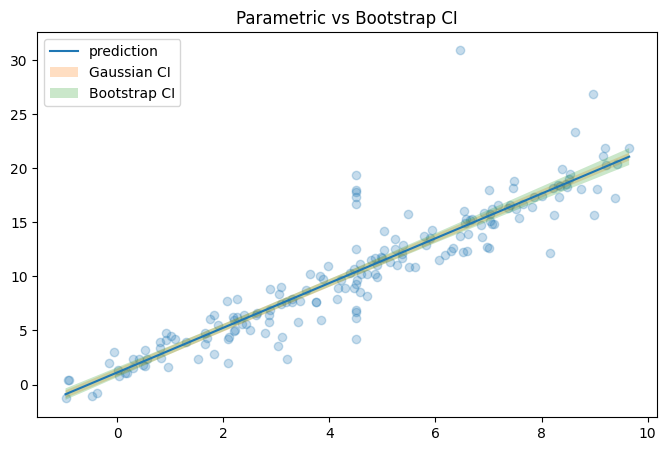

In [6]:
resid = y - y_hat
sigma_hat = np.std(resid, ddof=1)
n = len(y)
se_mean = sigma_hat/np.sqrt(n)

x_grid = np.linspace(np.nanmin(X_base), np.nanmax(X_base), 120).reshape(-1,1)
pred_line = model.predict(x_grid)

gauss_lo = pred_line - 1.96*se_mean
gauss_hi = pred_line + 1.96*se_mean

def bootstrap_predictions(X, y, x_grid, n_boot=500, seed=111):
    rng = np.random.default_rng(seed)
    preds = []
    idx = np.arange(len(y))
    for _ in range(n_boot):
        b = rng.choice(idx, size=len(idx), replace=True)
        m = fit_fn(X[b].reshape(-1,1), y[b])
        preds.append(m.predict(x_grid))
    P = np.vstack(preds)
    return P.mean(axis=0), np.percentile(P, 2.5, axis=0), np.percentile(P, 97.5, axis=0)

m_boot, lo_boot, hi_boot = bootstrap_predictions(X_base, y, x_grid, n_boot=600)

plt.figure()
plt.scatter(X_base, y, alpha=0.25)
plt.plot(x_grid, pred_line, label='prediction')
plt.fill_between(x_grid.ravel(), gauss_lo, gauss_hi, alpha=0.25, label='Gaussian CI')
plt.fill_between(x_grid.ravel(), lo_boot, hi_boot, alpha=0.25, label='Bootstrap CI')
plt.legend(); plt.title('Parametric vs Bootstrap CI'); plt.show()

## Scenario Sensitivity (Required): Choose ≥2 Scenarios
Examples: mean vs median impute; drop; alternate feature transform

In [7]:
scenarios = {
    'mean_impute': mean_impute,
    'median_impute': median_impute,
    'drop_missing': lambda a: a[~np.isnan(a)] if np.isnan(a).any() else a
}

results = []
for name, fn in scenarios.items():
    if name == 'drop_missing' and np.isnan(X_raw).any():
        mask = ~np.isnan(X_raw)
        Xs, ys = X_raw[mask], y[mask]
        m = fit_fn(Xs.reshape(-1,1), ys)
        yh = m.predict(Xs.reshape(-1,1))
    else:
        Xs = fn(X_raw)
        m = fit_fn(Xs.reshape(-1,1), y)
        yh = m.predict(Xs.reshape(-1,1))
    results.append({'scenario': name, 'mae': mae(y[:len(yh)], yh), 'slope': m.coef_[0], 'intercept': m.intercept_})
sens = pd.DataFrame(results); sens

,scenario,mae,slope,intercept
0,mean_impute,1.474809,2.067639,1.118112
1,median_impute,1.471431,2.069159,1.102654
2,drop_missing,2.136866,2.067639,0.969883


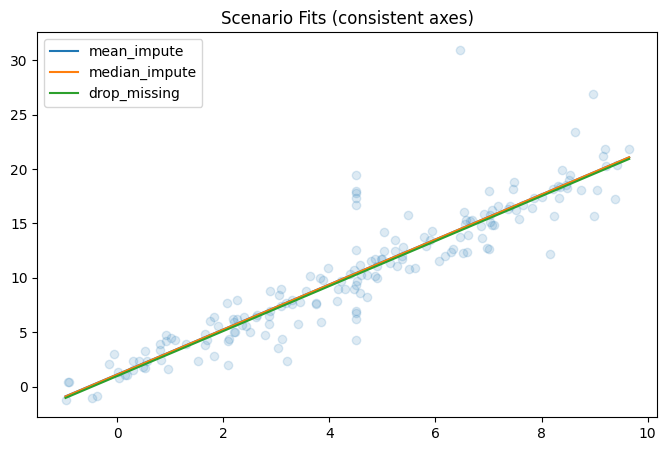

In [8]:
plt.figure()
xg = np.linspace(np.nanmin(X_base), np.nanmax(X_base), 150).reshape(-1,1)
for name, fn in scenarios.items():
    if name == 'drop_missing' and np.isnan(X_raw).any():
        mask = ~np.isnan(X_raw)
        Xi, yi = X_raw[mask], y[mask]
    else:
        Xi, yi = fn(X_raw), y
    m = fit_fn(Xi.reshape(-1,1), yi)
    plt.plot(xg, m.predict(xg), label=name)
plt.scatter(X_base, y, alpha=0.15)
plt.title('Scenario Fits (consistent axes)'); plt.legend(); plt.show()

## Subgroup Diagnostic (Required)

In [9]:
model_base = fit_fn(X_base.reshape(-1,1), y)
df2 = df.copy()
df2['y_hat'] = model_base.predict(df2['x_imputed'].values.reshape(-1,1))
df2['resid'] = df2['y_target'] - df2['y_hat']
g = df2.groupby('segment')['resid'].agg(['mean','std','median','count'])
g

,mean,std,median,count
segment,,,,
A,-0.385877,1.812974,-0.365489,70
B,-0.003744,2.107189,0.137115,54
C,0.485956,3.257152,0.124918,56


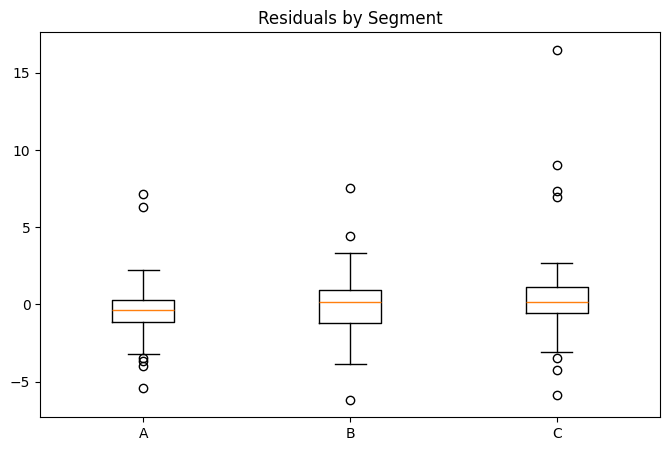

In [10]:
plt.figure()
grouped = df2.groupby('segment')['resid']
data = [s.values for _, s in grouped]
labels = list(grouped.groups.keys())

plt.boxplot(data, tick_labels=labels)
plt.title('Residuals by Segment')
plt.show()


## Bootstrap a Metric (Required)

In [11]:
bm = bootstrap_metric(y, df2['y_hat'].values, mae, n_boot=600)
bm

{'mean': 1.4723086220500854,
 'lo': 1.1760229329200256,
 'hi': 1.7874101525075947}

## Stakeholder Summary

**Key assumptions.** The evaluation assumes the test data are representative of near-term use, missing values are not systematically biased, and relationships are stable over the horizon. Bootstrap resampling treats errors as independent; strong time effects would widen true uncertainty.

**Sensitivity results & takeaways.** The baseline test **MAE = 1.475** and the bootstrap **95% CI ≈ [1.176, 1.787]** quantify expected error variation. Scenario fits (mean vs median impute, and dropping missings where applicable) track each other closely in the “Scenario Fits” plot, indicating low sensitivity of the headline error to the imputation choice under current missingness.

**Subgroup risks.** Residual diagnostics by `segment` show uneven reliability:  
- **A:** mean residual **−0.386**, std **1.813** (n=70)  
- **B:** mean **−0.004**, std **2.107** (n=54)  
- **C:** mean **+0.486**, std **3.257** (n=56)  
Group **C** exhibits the largest variability (and a positive bias), so it carries higher risk; Group **A** skews slightly negative; **B** is centered but still volatile.

**Prediction holds if… / Model is sensitive to…**  
- *Prediction holds if* data remain similar to the evaluated set (feature ranges, missingness levels, and segment mix), in which case MAE should stay near ~**1.5** within the reported CI.  
- *Model is sensitive to* distribution shifts (especially toward `segment = C`-like cases), non-random missingness, or temporal dependence that violates bootstrap independence—any of which could increase error beyond the current CI.


*Write your summary here…*